<a href="https://colab.research.google.com/github/adrianb896/testingWaldo/blob/main/WheresBinaryWaldo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm
import os
import math
import numpy as np
from PIL import Image, ImageChops, ImageOps

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# make all the images square and of same size
def crop_and_size(input_file_path, output_file_path, dimensions):
    # create a directory if it does not exist
    if not os.path.exists(output_file_path):
        os.makedirs(output_file_path)
    counter = 1
    for image in os.listdir(input_file_path):
        if image != '.DS_Store':
            img = Image.open(input_file_path + '/' + image)
            cropped_and_sized = ImageOps.fit(img, dimensions, Image.ANTIALIAS)
            cropped_and_sized.save(output_file_path + '/' + str(counter) + '.jpg', 'JPEG')
            counter += 1
crop_and_size('gdrive/MyDrive/Colab Notebooks/waldoPaths/', 'cropped-and-resized', (1024, 1024))

In [4]:
# chops the images into smaller images for use
def chop(x_div, y_div, input_file_path, output_file_path):
    # create a directory if it does not exist
    if not os.path.exists(output_file_path):
        os.makedirs(output_file_path)
    counter = 1
    for image in tqdm(os.listdir(input_file_path)):
        if image != '.DS_Store':
            img = Image.open(input_file_path + '/' + image)
            (imageWidth, imageHeight) = img.size
            gridx = x_div
            gridy = y_div
            rangex = int(imageWidth / gridx)
            rangey = int(imageHeight / gridy)
            for x in range(rangex):
                for y in range(rangey):
                    bbox = (x * gridx, y * gridy, x * gridx + gridx, y * gridy + gridy)
                    slice_bit = img.crop(bbox)
                    slice_bit.save(output_file_path + '/' + str(counter) + '_' + str(x) + '_' + str(y) + '.jpg',
                                   optimize=True, bits=6)
            counter += 1

chop(128, 128, 'gdrive/MyDrive/Colab Notebooks/waldoPaths/', 'chopped-128')

100%|██████████| 36/36 [00:06<00:00,  5.50it/s]


In [5]:
# flips the images horizontally
def flip_horizontally(input_file_path, output_file_path):
    # create a directory if it does not exist
    if not os.path.exists(output_file_path):
        os.makedirs(output_file_path)
    counter = 1
    for image in tqdm(os.listdir(input_file_path)):
        if image != '.DS_Store':
            # open the image and transpose horizontally
            flipped = Image.open(input_file_path + '/' + image).transpose(Image.FLIP_LEFT_RIGHT)
            # save the image
            flipped.save(output_file_path + '/' + str(counter) + '-flip' + '.jpg', optimize=True, bits=6)
            counter += 1
flip_horizontally('gdrive/MyDrive/Colab Notebooks/waldoPaths/', 'chopped-flipped')

100%|██████████| 36/36 [00:05<00:00,  6.17it/s]


In [6]:
# desaturates the images
def desaturate(input_file_path, output_file_path):
    # create a directory if it does not exist
    if not os.path.exists(output_file_path):
        os.makedirs(output_file_path)
    for image in tqdm(os.listdir(input_file_path)):
        if image != '.DS_Store':
            # open the image and convert to grayscale
            desaturated = Image.open(input_file_path + '/' + image).convert('1')
            # convert back to rgb
            desaturated = desaturated.convert('RGB')
            # save the image
            desaturated.save(output_file_path + '/' + image, optimize=True, bits=6)


desaturate('gdrive/MyDrive/Colab Notebooks/waldoPaths/', 'chopped-64')

100%|██████████| 36/36 [00:06<00:00,  5.67it/s]


In [7]:
def black_or_white(input_file_path, output_file_path):
    # create a directory if it does not exist
    if not os.path.exists(output_file_path):
        os.makedirs(output_file_path)
    for image in tqdm(os.listdir(input_file_path)):
        if image != '.DS_Store':
            # open the image and convert to black or white
            desaturated = Image.open(input_file_path + '/' + image).convert('L')
            bw = np.asarray(desaturated).copy()
            # pixel range is 0...255, 256/2 = 128
            bw[bw < 128] = 0    # Black
            bw[bw >= 128] = 255     # White
            # get the image from the converted array
            imfile = Image.fromarray(bw)
            # convert back to rgb
            imfile = imfile.convert('RGB')
            # save the image
            imfile.save(output_file_path + '/' + image, optimize=True, bits=6)
black_or_white('gdrive/MyDrive/Colab Notebooks/waldoPaths/', 'chopped-128-bw')

100%|██████████| 36/36 [00:07<00:00,  5.13it/s]


In [8]:
import cv2
from matplotlib import pyplot as plt

img_w = cv2.imread('/content/chopped-64/3.jpg')
w_gray = cv2.cvtColor(img_w, cv2.COLOR_BGR2GRAY)
template = cv2.imread('/content/chopped-128-bw/3.jpg',0)

# saves the width and height of the template into 'w' and 'h'
w, h = template.shape[::-1]
res = cv2.matchTemplate(w_gray,template,cv2.TM_CCOEFF_NORMED)

# finding the values where it exceeds the threshold
threshold = 0.6
loc = np.where( res >= threshold)

for pt in zip(*loc[::-1]):
    #draw rectangle on places where it exceeds threshold
    cv2.rectangle(img_w, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)
    print("Found Waldo: ", cv2.imwrite('/content/chopped-64/3.jpg', img_w))
    print("Found BW Waldo: ", cv2.imwrite('/content/chopped-128/11.jpg', template))

Found Waldo:  True
Found BW Waldo:  True


In [9]:
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import Image
from torchvision.utils import make_grid

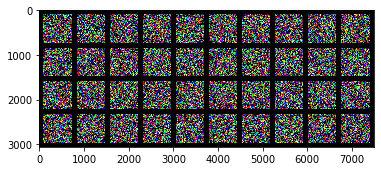

In [10]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

w = torch.randn(40,3,640,640)
grid = torchvision.utils.make_grid(w, nrow=10, padding=100)
show(grid)

Text(0.5, 1.0, 'distribution of pixels')

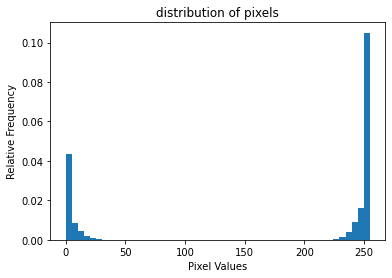

In [18]:
img_w = '/content/chopped-128-bw/3.jpg'
img = Image.open(img_w)
 
# convert PIL image to numpy array
img_np = np.array(img)
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("Pixel Values")
plt.ylabel("Relative Frequency")
plt.title("distribution of pixels")

Text(0.5, 1.0, 'distribution of pixels')

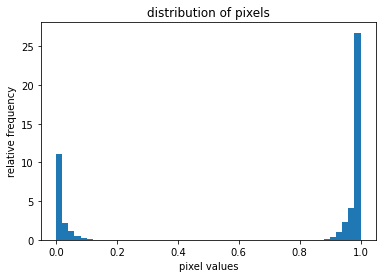

In [19]:
import torchvision.transforms as transforms
 
# define custom transform function
transform = transforms.Compose([
    transforms.ToTensor()
])
 
# transform the pIL image to tensor
# image
img_tr = transform(img)
 
# Convert tensor image to numpy array
img_np = np.array(img_tr)
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [25]:
img_tr = transform(img)
 
# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("mean image:", mean)
print("std image:", std)

mean and std before normalize:
mean image: tensor([0.6925, 0.6925, 0.6925])
std image: tensor([0.4477, 0.4477, 0.4477])


Text(0.5, 1.0, 'distribution of pixels')

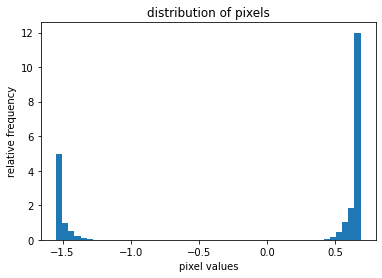

In [26]:
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # mean & std image
])
 
# get normalized image
img_normalized = transform_norm(img)
 
# convert normalized image to numpy
# array
img_np = np.array(img_normalized)
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

([], <a list of 0 Text major ticklabel objects>)

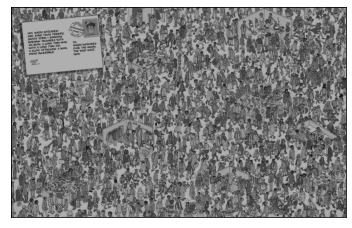

In [27]:
# Python Code to visualize normalized image
 
# get normalized image
img_normalized = transform_norm(img)
 
# convert this image to numpy array
img_normalized = np.array(img_normalized)
 
# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)
 
# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

In [28]:
# get normalized image
img_normalization = transform_norm(img)
 
# cailculate mean and std
mean, std = img_normalization.mean([1,2]), img_normalization.std([1,2])
 
# print mean and std
print("mean and std of normalized image:")
print("mean of the image:", mean)
print("std of the image:", std)

mean and std of normalized image:
mean of the image: tensor([-8.1099e-08, -8.1099e-08, -8.1099e-08])
std of the image: tensor([1., 1., 1.])
